In [1]:
trial_number_ml = "006"
random_state_init = 666

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 16:42:21,340] A new study created in memory with name: no-name-4f510bd5-2f8d-45a0-bbf4-7ffce9ad4c8e


[I 2024-05-01 16:43:16,917] Trial 0 finished with value: 0.7284049004967542 and parameters: {'n_estimators': 319, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7284049004967542.


[I 2024-05-01 16:43:39,673] Trial 1 finished with value: 0.7284069322118266 and parameters: {'n_estimators': 468, 'max_depth': 84, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7284069322118266.


[I 2024-05-01 16:44:18,305] Trial 3 finished with value: 0.7309562266987678 and parameters: {'n_estimators': 747, 'max_depth': 61, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 3 with value: 0.7309562266987678.


[I 2024-05-01 16:44:33,827] Trial 2 finished with value: 0.7277694816078993 and parameters: {'n_estimators': 792, 'max_depth': 62, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7309562266987678.


[I 2024-05-01 16:44:35,774] Trial 5 finished with value: 0.7271360944341165 and parameters: {'n_estimators': 378, 'max_depth': 69, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 3 with value: 0.7309562266987678.


[I 2024-05-01 16:44:36,730] Trial 6 pruned. 


[I 2024-05-01 16:44:44,702] Trial 8 pruned. 


[I 2024-05-01 16:44:57,425] Trial 7 pruned. 


[I 2024-05-01 16:45:00,234] Trial 4 finished with value: 0.7268160993102327 and parameters: {'n_estimators': 681, 'max_depth': 80, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 3 with value: 0.7309562266987678.


[I 2024-05-01 16:45:05,489] Trial 11 pruned. 


[I 2024-05-01 16:45:08,305] Trial 10 pruned. 


[I 2024-05-01 16:46:06,140] Trial 12 finished with value: 0.7331875577768974 and parameters: {'n_estimators': 372, 'max_depth': 85, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.7331875577768974.


[I 2024-05-01 16:46:54,180] Trial 14 finished with value: 0.7497617814077754 and parameters: {'n_estimators': 515, 'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:46:57,792] Trial 9 finished with value: 0.7414759394142566 and parameters: {'n_estimators': 759, 'max_depth': 74, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:47:15,840] Trial 16 finished with value: 0.7437072704923862 and parameters: {'n_estimators': 104, 'max_depth': 45, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:47:20,491] Trial 17 finished with value: 0.7366907424902731 and parameters: {'n_estimators': 109, 'max_depth': 44, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:47:38,693] Trial 18 finished with value: 0.735732788833694 and parameters: {'n_estimators': 106, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:48:23,594] Trial 13 finished with value: 0.7427483009782708 and parameters: {'n_estimators': 981, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:48:45,941] Trial 21 pruned. 


[I 2024-05-01 16:49:15,080] Trial 19 finished with value: 0.7488068753238046 and parameters: {'n_estimators': 554, 'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:49:24,325] Trial 15 finished with value: 0.7440247259724295 and parameters: {'n_estimators': 979, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:49:25,619] Trial 20 finished with value: 0.741793902823068 and parameters: {'n_estimators': 523, 'max_depth': 44, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:50:29,890] Trial 22 finished with value: 0.7465765601032112 and parameters: {'n_estimators': 519, 'max_depth': 52, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:50:53,786] Trial 26 pruned. 


[I 2024-05-01 16:51:06,576] Trial 23 finished with value: 0.7459411412143562 and parameters: {'n_estimators': 560, 'max_depth': 98, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:51:12,214] Trial 24 finished with value: 0.7462560570505592 and parameters: {'n_estimators': 545, 'max_depth': 53, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:52:24,802] Trial 27 finished with value: 0.7446601448612847 and parameters: {'n_estimators': 464, 'max_depth': 54, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:52:36,744] Trial 28 finished with value: 0.7449801399851684 and parameters: {'n_estimators': 460, 'max_depth': 52, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:52:38,276] Trial 25 finished with value: 0.7472135027783704 and parameters: {'n_estimators': 999, 'max_depth': 53, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:52:39,110] Trial 29 finished with value: 0.7421108503743434 and parameters: {'n_estimators': 461, 'max_depth': 31, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:52:44,024] Trial 30 pruned. 


[I 2024-05-01 16:53:16,238] Trial 33 pruned. 


[I 2024-05-01 16:53:24,874] Trial 34 pruned. 


[I 2024-05-01 16:53:28,224] Trial 35 pruned. 


[I 2024-05-01 16:53:46,942] Trial 37 pruned. 


[I 2024-05-01 16:55:12,343] Trial 32 finished with value: 0.7379697071282724 and parameters: {'n_estimators': 628, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:55:13,534] Trial 31 finished with value: 0.7421103424455754 and parameters: {'n_estimators': 659, 'max_depth': 29, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:55:33,263] Trial 38 finished with value: 0.7427493168358069 and parameters: {'n_estimators': 405, 'max_depth': 48, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:55:36,706] Trial 40 pruned. 


[I 2024-05-01 16:55:50,722] Trial 41 pruned. 


[I 2024-05-01 16:55:59,506] Trial 36 finished with value: 0.7440247259724295 and parameters: {'n_estimators': 632, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:56:05,792] Trial 42 pruned. 


[I 2024-05-01 16:56:18,333] Trial 43 pruned. 


[I 2024-05-01 16:56:38,823] Trial 44 pruned. 


[I 2024-05-01 16:56:49,028] Trial 46 pruned. 


[I 2024-05-01 16:57:01,325] Trial 39 finished with value: 0.7430672802446184 and parameters: {'n_estimators': 418, 'max_depth': 67, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:57:09,582] Trial 47 pruned. 


[I 2024-05-01 16:58:30,172] Trial 45 finished with value: 0.7478499375247616 and parameters: {'n_estimators': 741, 'max_depth': 58, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:58:32,232] Trial 49 finished with value: 0.7443472607401538 and parameters: {'n_estimators': 536, 'max_depth': 49, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


[I 2024-05-01 16:58:44,939] Trial 48 finished with value: 0.7459401253568199 and parameters: {'n_estimators': 928, 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7497617814077754.


Best trial for RandomForestClassifier:
  Value: 0.7497617814077754
  Params: 
    n_estimators: 515
    max_depth: 44
    min_samples_split: 7
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 515, 'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 16:58:56,966] A new study created in memory with name: no-name-d21888ae-da1d-40b3-a3c2-1c3a9dd4a75b


RandomForestClassifier accuracy: 0.7427



[I 2024-05-01 16:59:07,793] Trial 2 finished with value: 0.7210780280173508 and parameters: {'n_estimators': 117, 'max_depth': 7, 'learning_rate': 0.14273332370240985, 'min_child_weight': 10, 'subsample': 0.9916841662003988, 'colsample_bytree': 0.5885288174450058, 'gamma': 4.882826910849301, 'reg_lambda': 3.0455722036679562, 'reg_alpha': 0.10656172791117523}. Best is trial 2 with value: 0.7210780280173508.


[I 2024-05-01 16:59:14,419] Trial 3 finished with value: 0.7335116163309257 and parameters: {'n_estimators': 130, 'max_depth': 5, 'learning_rate': 0.11927975325968301, 'min_child_weight': 1, 'subsample': 0.739818422760337, 'colsample_bytree': 0.7621919160871344, 'gamma': 4.7067840723437895, 'reg_lambda': 0.11216817488901251, 'reg_alpha': 0.6884595279955824}. Best is trial 3 with value: 0.7335116163309257.


[I 2024-05-01 16:59:20,222] Trial 4 finished with value: 0.7290469224595942 and parameters: {'n_estimators': 113, 'max_depth': 4, 'learning_rate': 0.2533552426848823, 'min_child_weight': 6, 'subsample': 0.8114376058988857, 'colsample_bytree': 0.6741768966328605, 'gamma': 3.019704843679445, 'reg_lambda': 1.9863901906038988, 'reg_alpha': 0.023956314254698012}. Best is trial 3 with value: 0.7335116163309257.


[I 2024-05-01 16:59:49,978] Trial 1 finished with value: 0.7229878401852924 and parameters: {'n_estimators': 362, 'max_depth': 7, 'learning_rate': 0.06858709553883986, 'min_child_weight': 9, 'subsample': 0.856328807461288, 'colsample_bytree': 0.8558548539170143, 'gamma': 1.285368134488969, 'reg_lambda': 0.07742592365134066, 'reg_alpha': 0.17331247255941545}. Best is trial 3 with value: 0.7335116163309257.


[I 2024-05-01 17:00:26,658] Trial 5 finished with value: 0.7315982486616077 and parameters: {'n_estimators': 591, 'max_depth': 6, 'learning_rate': 0.018508743027226476, 'min_child_weight': 4, 'subsample': 0.9213303557191892, 'colsample_bytree': 0.9222647863297124, 'gamma': 3.1112056701490385, 'reg_lambda': 0.02104597104241453, 'reg_alpha': 0.2737458522543683}. Best is trial 3 with value: 0.7335116163309257.


[I 2024-05-01 17:00:26,671] Trial 0 pruned. 


[I 2024-05-01 17:00:27,472] Trial 7 finished with value: 0.7402045937077785 and parameters: {'n_estimators': 541, 'max_depth': 5, 'learning_rate': 0.10217520947510504, 'min_child_weight': 1, 'subsample': 0.8816182005941506, 'colsample_bytree': 0.6582872583489687, 'gamma': 3.545209461531237, 'reg_lambda': 3.539182059112918, 'reg_alpha': 0.048096190455347965}. Best is trial 7 with value: 0.7402045937077785.


[I 2024-05-01 17:00:29,475] Trial 10 pruned. 


[I 2024-05-01 17:00:29,644] Trial 9 pruned. 


[I 2024-05-01 17:00:31,113] Trial 6 pruned. 


[I 2024-05-01 17:00:34,431] Trial 11 finished with value: 0.7284079480693627 and parameters: {'n_estimators': 114, 'max_depth': 10, 'learning_rate': 0.2414265018732626, 'min_child_weight': 6, 'subsample': 0.6534344660231259, 'colsample_bytree': 0.9494833686042552, 'gamma': 4.531248874603548, 'reg_lambda': 3.1445534994137136, 'reg_alpha': 0.11615469131151349}. Best is trial 7 with value: 0.7402045937077785.


[I 2024-05-01 17:00:35,886] Trial 13 pruned. 


[I 2024-05-01 17:00:36,104] Trial 8 finished with value: 0.7309531791261593 and parameters: {'n_estimators': 180, 'max_depth': 5, 'learning_rate': 0.11587826794725689, 'min_child_weight': 9, 'subsample': 0.6199112295840155, 'colsample_bytree': 0.9344996934207872, 'gamma': 2.0401930294768125, 'reg_lambda': 3.930259497055664, 'reg_alpha': 0.7139946765493761}. Best is trial 7 with value: 0.7402045937077785.


[I 2024-05-01 17:00:36,547] Trial 14 pruned. 


[I 2024-05-01 17:00:38,598] Trial 17 pruned. 


[I 2024-05-01 17:00:39,528] Trial 16 pruned. 


[I 2024-05-01 17:00:42,846] Trial 15 finished with value: 0.7322362071943032 and parameters: {'n_estimators': 196, 'max_depth': 5, 'learning_rate': 0.08947173960466843, 'min_child_weight': 1, 'subsample': 0.8081040341078269, 'colsample_bytree': 0.7741594710642982, 'gamma': 3.8449915723650117, 'reg_lambda': 0.20858546675660744, 'reg_alpha': 1.0239225635948055}. Best is trial 7 with value: 0.7402045937077785.


[I 2024-05-01 17:00:50,039] Trial 19 finished with value: 0.7370158169018377 and parameters: {'n_estimators': 261, 'max_depth': 8, 'learning_rate': 0.11591777951742004, 'min_child_weight': 3, 'subsample': 0.869244732312813, 'colsample_bytree': 0.8016016016010875, 'gamma': 4.108553624731774, 'reg_lambda': 0.9945508210354383, 'reg_alpha': 1.284101851391812}. Best is trial 7 with value: 0.7402045937077785.


[I 2024-05-01 17:00:53,770] Trial 20 finished with value: 0.7351009254462154 and parameters: {'n_estimators': 259, 'max_depth': 8, 'learning_rate': 0.14508994295733119, 'min_child_weight': 3, 'subsample': 0.8829356355559557, 'colsample_bytree': 0.821008228277132, 'gamma': 4.932056552611306, 'reg_lambda': 1.1012993010655907, 'reg_alpha': 0.04769980595894719}. Best is trial 7 with value: 0.7402045937077785.


[I 2024-05-01 17:00:57,821] Trial 22 pruned. 


[I 2024-05-01 17:00:59,692] Trial 18 finished with value: 0.739566127246315 and parameters: {'n_estimators': 549, 'max_depth': 8, 'learning_rate': 0.06876165354181302, 'min_child_weight': 3, 'subsample': 0.8785501187839186, 'colsample_bytree': 0.7943742708142131, 'gamma': 3.699104949444766, 'reg_lambda': 0.9184932797172252, 'reg_alpha': 0.7029297442926558}. Best is trial 7 with value: 0.7402045937077785.


[I 2024-05-01 17:01:00,071] Trial 12 finished with value: 0.7226719084915532 and parameters: {'n_estimators': 666, 'max_depth': 7, 'learning_rate': 0.123103827176744, 'min_child_weight': 5, 'subsample': 0.9090837586767078, 'colsample_bytree': 0.9515196851425793, 'gamma': 0.27877837305751274, 'reg_lambda': 5.861779306460133, 'reg_alpha': 2.079332702856331}. Best is trial 7 with value: 0.7402045937077785.


[I 2024-05-01 17:01:00,620] Trial 23 pruned. 


[I 2024-05-01 17:01:03,445] Trial 21 finished with value: 0.7351004175174474 and parameters: {'n_estimators': 298, 'max_depth': 8, 'learning_rate': 0.15797261234321106, 'min_child_weight': 3, 'subsample': 0.9036612735232148, 'colsample_bytree': 0.8577870474143623, 'gamma': 3.3722856001115, 'reg_lambda': 0.9311065086368692, 'reg_alpha': 1.8289723839176106}. Best is trial 7 with value: 0.7402045937077785.


[I 2024-05-01 17:01:04,881] Trial 25 pruned. 


[I 2024-05-01 17:01:19,704] Trial 28 finished with value: 0.7411640711506617 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.09519807979185517, 'min_child_weight': 2, 'subsample': 0.9496189337228049, 'colsample_bytree': 0.7915677668543956, 'gamma': 3.473544066312219, 'reg_lambda': 0.4863804119553693, 'reg_alpha': 0.5210851128981777}. Best is trial 28 with value: 0.7411640711506617.


[I 2024-05-01 17:01:21,827] Trial 27 finished with value: 0.7395681589613873 and parameters: {'n_estimators': 462, 'max_depth': 9, 'learning_rate': 0.039564559306395616, 'min_child_weight': 2, 'subsample': 0.8416404117418746, 'colsample_bytree': 0.8028383159272201, 'gamma': 4.255758739991481, 'reg_lambda': 1.4593013777961616, 'reg_alpha': 0.46566251323526364}. Best is trial 28 with value: 0.7411640711506617.


[I 2024-05-01 17:01:23,133] Trial 29 pruned. 


[I 2024-05-01 17:01:23,821] Trial 30 pruned. 


[I 2024-05-01 17:01:24,892] Trial 24 finished with value: 0.7363783662979103 and parameters: {'n_estimators': 426, 'max_depth': 9, 'learning_rate': 0.043225207702711044, 'min_child_weight': 5, 'subsample': 0.8640706071167497, 'colsample_bytree': 0.8703747164242929, 'gamma': 2.50702860938149, 'reg_lambda': 7.304054842544834, 'reg_alpha': 0.4650524847822351}. Best is trial 28 with value: 0.7411640711506617.


[I 2024-05-01 17:01:30,279] Trial 33 pruned. 


[I 2024-05-01 17:01:33,329] Trial 26 finished with value: 0.7366988693505623 and parameters: {'n_estimators': 969, 'max_depth': 9, 'learning_rate': 0.09581661761236905, 'min_child_weight': 3, 'subsample': 0.8599777518364513, 'colsample_bytree': 0.8041575002573343, 'gamma': 4.245381707441628, 'reg_lambda': 1.409035599497271, 'reg_alpha': 0.36740216462339137}. Best is trial 28 with value: 0.7411640711506617.


[I 2024-05-01 17:01:48,056] Trial 31 finished with value: 0.7481734881500219 and parameters: {'n_estimators': 687, 'max_depth': 10, 'learning_rate': 0.0449839595636876, 'min_child_weight': 2, 'subsample': 0.9447955643603154, 'colsample_bytree': 0.6815417337899955, 'gamma': 2.5478982370203993, 'reg_lambda': 2.2667691851918232, 'reg_alpha': 0.05657909266164791}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:01:50,790] Trial 35 finished with value: 0.7405240809028941 and parameters: {'n_estimators': 582, 'max_depth': 8, 'learning_rate': 0.05400288057395366, 'min_child_weight': 2, 'subsample': 0.9607080194617268, 'colsample_bytree': 0.7315955690400479, 'gamma': 3.6488235732305156, 'reg_lambda': 0.6591934893898788, 'reg_alpha': 0.6394921686302886}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:01:51,096] Trial 34 finished with value: 0.7379702150570404 and parameters: {'n_estimators': 543, 'max_depth': 9, 'learning_rate': 0.058165491315677935, 'min_child_weight': 2, 'subsample': 0.9689700615251786, 'colsample_bytree': 0.7924016722619283, 'gamma': 3.582394787340965, 'reg_lambda': 4.490283729199057, 'reg_alpha': 0.5142312771672958}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:01:54,752] Trial 32 finished with value: 0.742757443696096 and parameters: {'n_estimators': 717, 'max_depth': 10, 'learning_rate': 0.042590218714752395, 'min_child_weight': 2, 'subsample': 0.9623148537288188, 'colsample_bytree': 0.6450847186966662, 'gamma': 4.291204223811833, 'reg_lambda': 2.030939308142494, 'reg_alpha': 0.03944802464957992}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:01:55,939] Trial 38 pruned. 


[I 2024-05-01 17:02:03,623] Trial 39 pruned. 


[I 2024-05-01 17:02:10,537] Trial 41 pruned. 


[I 2024-05-01 17:02:15,605] Trial 42 pruned. 


[I 2024-05-01 17:02:15,697] Trial 36 finished with value: 0.7386122370198802 and parameters: {'n_estimators': 680, 'max_depth': 10, 'learning_rate': 0.05545713197873835, 'min_child_weight': 2, 'subsample': 0.9583391696203446, 'colsample_bytree': 0.5524049349942353, 'gamma': 2.2020618809963444, 'reg_lambda': 2.4163487803550256, 'reg_alpha': 0.05367760122610557}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:02:18,902] Trial 37 finished with value: 0.7414774632005607 and parameters: {'n_estimators': 718, 'max_depth': 10, 'learning_rate': 0.060774100595107905, 'min_child_weight': 4, 'subsample': 0.9654984347636316, 'colsample_bytree': 0.7335484477486118, 'gamma': 2.079890421974638, 'reg_lambda': 4.670083428739114, 'reg_alpha': 0.07184820928281703}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:02:30,713] Trial 40 finished with value: 0.7386137608061846 and parameters: {'n_estimators': 786, 'max_depth': 10, 'learning_rate': 0.05268406600744615, 'min_child_weight': 4, 'subsample': 0.9614730020423696, 'colsample_bytree': 0.5763719456750611, 'gamma': 1.576274702629731, 'reg_lambda': 0.09895485062672373, 'reg_alpha': 0.20823237373981024}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:02:35,476] Trial 46 pruned. 


[I 2024-05-01 17:02:42,575] Trial 47 pruned. 


[I 2024-05-01 17:02:50,291] Trial 45 finished with value: 0.7360593870315627 and parameters: {'n_estimators': 786, 'max_depth': 9, 'learning_rate': 0.02910742664840855, 'min_child_weight': 8, 'subsample': 0.8996454666224731, 'colsample_bytree': 0.726797002712225, 'gamma': 3.102779338706102, 'reg_lambda': 5.85788805105781, 'reg_alpha': 0.08035919559683041}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:02:50,458] Trial 48 pruned. 


[I 2024-05-01 17:02:50,688] Trial 43 finished with value: 0.7376578388646775 and parameters: {'n_estimators': 805, 'max_depth': 8, 'learning_rate': 0.055887315618044504, 'min_child_weight': 1, 'subsample': 0.9978943053257069, 'colsample_bytree': 0.5762465131490537, 'gamma': 2.90906165424028, 'reg_lambda': 2.2947781012003574, 'reg_alpha': 0.029644278608028072}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:02:51,826] Trial 44 finished with value: 0.7347839778949401 and parameters: {'n_estimators': 817, 'max_depth': 3, 'learning_rate': 0.021905239435371333, 'min_child_weight': 1, 'subsample': 0.9026228200752414, 'colsample_bytree': 0.6549845107327644, 'gamma': 3.2958131184123634, 'reg_lambda': 4.383274195657297, 'reg_alpha': 0.03112805816115869}. Best is trial 31 with value: 0.7481734881500219.


[I 2024-05-01 17:02:53,940] Trial 49 pruned. 


Best trial for XGBClassifier:
  Value: 0.7481734881500219
  Params: 
    n_estimators: 687
    max_depth: 10
    learning_rate: 0.0449839595636876
    min_child_weight: 2
    subsample: 0.9447955643603154
    colsample_bytree: 0.6815417337899955
    gamma: 2.5478982370203993
    reg_lambda: 2.2667691851918232
    reg_alpha: 0.05657909266164791

Best hyperparameters for XGBClassifier: {'n_estimators': 687, 'max_depth': 10, 'learning_rate': 0.0449839595636876, 'min_child_weight': 2, 'subsample': 0.9447955643603154, 'colsample_bytree': 0.6815417337899955, 'gamma': 2.5478982370203993, 'reg_lambda': 2.2667691851918232, 'reg_alpha': 0.05657909266164791}


[I 2024-05-01 17:04:06,566] A new study created in memory with name: no-name-06397520-6793-4726-88fc-225de573b508


XGBClassifier accuracy: 0.7376



[I 2024-05-01 17:04:07,196] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'max_depth': 0, 'learning_rate': 0.0024108513525175966, 'n_estimators': 126, 'min_child_weight': 0.002169506908793403, 'min_child_samples': 1621, 'subsample': 0.8510665991609838, 'colsample_bytree': 0.8982833734689388, 'reg_alpha': 0.4208013462907205, 'reg_lambda': 6.535477311850539e-07}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 17:04:07,440] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'max_depth': 7, 'learning_rate': 0.13072930197780105, 'n_estimators': 507, 'min_child_weight': 0.07903024079065653, 'min_child_samples': 1715, 'subsample': 0.8214544362759032, 'colsample_bytree': 0.8461261899984793, 'reg_alpha': 3.398300355602999e-10, 'reg_lambda': 3.245401265987362e-10}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 17:04:08,079] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 8, 'learning_rate': 0.3691702723107618, 'n_estimators': 423, 'min_child_weight': 0.009746458175834803, 'min_child_samples': 1602, 'subsample': 0.9677298336838721, 'colsample_bytree': 0.9824549815988335, 'reg_alpha': 3.515933789459483e-05, 'reg_lambda': 2.215319186481518e-08}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 17:04:09,243] Trial 3 finished with value: 0.62352522882191 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 1, 'learning_rate': 0.11408858426376157, 'n_estimators': 640, 'min_child_weight': 0.0029211125194723484, 'min_child_samples': 980, 'subsample': 0.8664653595692849, 'colsample_bytree': 0.99648099171373, 'reg_alpha': 0.002091819169658254, 'reg_lambda': 5.436607594983555e-06}. Best is trial 3 with value: 0.62352522882191.


[I 2024-05-01 17:04:10,146] Trial 7 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'max_depth': 13, 'learning_rate': 0.13218420898150274, 'n_estimators': 939, 'min_child_weight': 0.025200289691158943, 'min_child_samples': 1524, 'subsample': 0.9681762004761147, 'colsample_bytree': 0.8153357084243121, 'reg_alpha': 2.9655144314507004e-09, 'reg_lambda': 3.69363449072201e-05}. Best is trial 3 with value: 0.62352522882191.


[I 2024-05-01 17:04:10,868] Trial 6 finished with value: 0.5906993163278782 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': 0, 'learning_rate': 0.024016275985983108, 'n_estimators': 809, 'min_child_weight': 0.006566747796571099, 'min_child_samples': 1081, 'subsample': 0.8036053525560999, 'colsample_bytree': 0.9561434103311158, 'reg_alpha': 4.940472828757002e-07, 'reg_lambda': 1.3843551509828172e-08}. Best is trial 3 with value: 0.62352522882191.


[I 2024-05-01 17:04:11,513] Trial 9 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 54, 'max_depth': 2, 'learning_rate': 0.3625578716479635, 'n_estimators': 506, 'min_child_weight': 0.02773485135835129, 'min_child_samples': 1560, 'subsample': 0.8976140907890888, 'colsample_bytree': 0.9811819671865578, 'reg_alpha': 2.1714189199423587e-05, 'reg_lambda': 2.2078532784520465e-08}. Best is trial 3 with value: 0.62352522882191.


[I 2024-05-01 17:04:12,195] Trial 10 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 1, 'learning_rate': 0.32992730715927665, 'n_estimators': 670, 'min_child_weight': 0.0012405087993858839, 'min_child_samples': 1622, 'subsample': 0.9163588498868651, 'colsample_bytree': 0.8948111795092419, 'reg_alpha': 0.0005230872635598806, 'reg_lambda': 0.004918073642720957}. Best is trial 3 with value: 0.62352522882191.


[I 2024-05-01 17:04:13,855] Trial 1 finished with value: 0.5763488048436087 and parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'max_depth': 3, 'learning_rate': 0.0230801938810178, 'n_estimators': 478, 'min_child_weight': 0.031520947830922685, 'min_child_samples': 1094, 'subsample': 0.8483625796265216, 'colsample_bytree': 0.827984730039883, 'reg_alpha': 9.278142922391518e-08, 'reg_lambda': 1.8571839254423793e-10}. Best is trial 3 with value: 0.62352522882191.


[I 2024-05-01 17:04:14,627] Trial 12 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 86, 'max_depth': 1, 'learning_rate': 0.2438348803701848, 'n_estimators': 388, 'min_child_weight': 0.006007075165152484, 'min_child_samples': 1549, 'subsample': 0.8899626064156854, 'colsample_bytree': 0.9024552501552918, 'reg_alpha': 0.23973848186456884, 'reg_lambda': 3.8390449620766854e-07}. Best is trial 3 with value: 0.62352522882191.


[I 2024-05-01 17:04:16,057] Trial 11 finished with value: 0.6805920417720619 and parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'max_depth': 1, 'learning_rate': 0.20020402974180768, 'n_estimators': 364, 'min_child_weight': 0.0026325164446318145, 'min_child_samples': 362, 'subsample': 0.8016665226581549, 'colsample_bytree': 0.9856302939765749, 'reg_alpha': 4.539468527970232e-09, 'reg_lambda': 9.027944124941912e-10}. Best is trial 11 with value: 0.6805920417720619.


[I 2024-05-01 17:04:18,371] Trial 14 finished with value: 0.6605115858551996 and parameters: {'boosting_type': 'goss', 'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.19337806510056454, 'n_estimators': 233, 'min_child_weight': 0.0030104762894680795, 'min_child_samples': 288, 'subsample': 0.8495130089070977, 'colsample_bytree': 0.9996569430342068, 'reg_alpha': 0.0006339076089104415, 'reg_lambda': 0.34126781591681227}. Best is trial 11 with value: 0.6805920417720619.


[I 2024-05-01 17:04:19,127] Trial 13 finished with value: 0.664646633956054 and parameters: {'boosting_type': 'goss', 'num_leaves': 33, 'max_depth': 5, 'learning_rate': 0.4836529763378796, 'n_estimators': 212, 'min_child_weight': 0.002853633859683091, 'min_child_samples': 102, 'subsample': 0.998926593498437, 'colsample_bytree': 0.9413629355061703, 'reg_alpha': 0.006012907576548526, 'reg_lambda': 0.6444612665408668}. Best is trial 11 with value: 0.6805920417720619.


[I 2024-05-01 17:04:22,327] Trial 15 finished with value: 0.6815449161409604 and parameters: {'boosting_type': 'goss', 'num_leaves': 32, 'max_depth': 5, 'learning_rate': 0.4805442342437918, 'n_estimators': 216, 'min_child_weight': 0.0030419026401808952, 'min_child_samples': 134, 'subsample': 0.8244964479480994, 'colsample_bytree': 0.9470418389154733, 'reg_alpha': 6.034020599183488e-08, 'reg_lambda': 0.07303926352452145}. Best is trial 15 with value: 0.6815449161409604.


[I 2024-05-01 17:04:24,058] Trial 17 finished with value: 0.6512693139914059 and parameters: {'boosting_type': 'goss', 'num_leaves': 46, 'max_depth': 10, 'learning_rate': 0.49643466376169937, 'n_estimators': 318, 'min_child_weight': 0.0013687445885910354, 'min_child_samples': 507, 'subsample': 0.8008485560519569, 'colsample_bytree': 0.9413116285984643, 'reg_alpha': 4.452436004830995e-08, 'reg_lambda': 0.0018608371385443424}. Best is trial 15 with value: 0.6815449161409604.


[I 2024-05-01 17:04:24,322] Trial 4 finished with value: 0.6343674763051229 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 6, 'learning_rate': 0.2124153856298243, 'n_estimators': 811, 'min_child_weight': 0.0018688961506212708, 'min_child_samples': 772, 'subsample': 0.8691647213218511, 'colsample_bytree': 0.9721811974384742, 'reg_alpha': 0.002345351580021624, 'reg_lambda': 0.5311937044967364}. Best is trial 15 with value: 0.6815449161409604.


[I 2024-05-01 17:04:25,368] Trial 18 finished with value: 0.6423378945336706 and parameters: {'boosting_type': 'goss', 'num_leaves': 99, 'max_depth': 4, 'learning_rate': 0.29370560061371115, 'n_estimators': 280, 'min_child_weight': 0.00562485890897389, 'min_child_samples': 653, 'subsample': 0.8268625472929378, 'colsample_bytree': 0.9607250478583552, 'reg_alpha': 3.740447971999751e-09, 'reg_lambda': 0.000603852324699801}. Best is trial 15 with value: 0.6815449161409604.


[I 2024-05-01 17:04:25,968] Trial 8 finished with value: 0.5906993163278782 and parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 4, 'learning_rate': 0.3527319029866352, 'n_estimators': 772, 'min_child_weight': 0.004381861144932152, 'min_child_samples': 1071, 'subsample': 0.8584359938288093, 'colsample_bytree': 0.8920443087999926, 'reg_alpha': 1.0234703101005404e-06, 'reg_lambda': 1.7040946456095468e-06}. Best is trial 15 with value: 0.6815449161409604.


[I 2024-05-01 17:04:26,425] Trial 16 finished with value: 0.6573197614766505 and parameters: {'boosting_type': 'goss', 'num_leaves': 35, 'max_depth': 10, 'learning_rate': 0.4958204331637783, 'n_estimators': 284, 'min_child_weight': 0.0011297827496641758, 'min_child_samples': 80, 'subsample': 0.9331237296315728, 'colsample_bytree': 0.9436169766047507, 'reg_alpha': 8.901152293731658e-08, 'reg_lambda': 0.0005079407370328257}. Best is trial 15 with value: 0.6815449161409604.


[I 2024-05-01 17:04:27,741] Trial 20 finished with value: 0.6844269039709872 and parameters: {'boosting_type': 'goss', 'num_leaves': 44, 'max_depth': 15, 'learning_rate': 0.41714144022371624, 'n_estimators': 123, 'min_child_weight': 0.004331942090352041, 'min_child_samples': 140, 'subsample': 0.9241366501466686, 'colsample_bytree': 0.9217213060306969, 'reg_alpha': 1.2518934250351601e-06, 'reg_lambda': 0.0001085683169406562}. Best is trial 20 with value: 0.6844269039709872.


[I 2024-05-01 17:04:27,973] Trial 23 pruned. 


[I 2024-05-01 17:04:28,131] Trial 22 finished with value: 0.6933415617793761 and parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'max_depth': -1, 'learning_rate': 0.4256868756428098, 'n_estimators': 127, 'min_child_weight': 0.014000523287028312, 'min_child_samples': 373, 'subsample': 0.8340366551977114, 'colsample_bytree': 0.9182170023930589, 'reg_alpha': 1.7002506426180977e-10, 'reg_lambda': 0.02502273661734156}. Best is trial 22 with value: 0.6933415617793761.


[I 2024-05-01 17:04:29,272] Trial 24 finished with value: 0.6560448602687959 and parameters: {'boosting_type': 'goss', 'num_leaves': 41, 'max_depth': 11, 'learning_rate': 0.42636006990365266, 'n_estimators': 112, 'min_child_weight': 0.0040656087790955815, 'min_child_samples': 289, 'subsample': 0.8258370208455387, 'colsample_bytree': 0.9210910145907423, 'reg_alpha': 5.77683052484515e-09, 'reg_lambda': 4.774683984889942e-05}. Best is trial 22 with value: 0.6933415617793761.


[I 2024-05-01 17:04:30,824] Trial 21 finished with value: 0.6697538577189934 and parameters: {'boosting_type': 'goss', 'num_leaves': 91, 'max_depth': 9, 'learning_rate': 0.42330054679296325, 'n_estimators': 112, 'min_child_weight': 0.0010822433084050327, 'min_child_samples': 54, 'subsample': 0.8255737672364601, 'colsample_bytree': 0.9328128612958585, 'reg_alpha': 1.1546309349856377e-10, 'reg_lambda': 0.02864567475803011}. Best is trial 22 with value: 0.6933415617793761.


[I 2024-05-01 17:04:31,117] Trial 27 pruned. 


[I 2024-05-01 17:04:32,740] Trial 19 finished with value: 0.6888768679080446 and parameters: {'boosting_type': 'goss', 'num_leaves': 94, 'max_depth': 4, 'learning_rate': 0.29319698561975205, 'n_estimators': 273, 'min_child_weight': 0.004870799483235025, 'min_child_samples': 52, 'subsample': 0.8228188718540435, 'colsample_bytree': 0.9257916062723803, 'reg_alpha': 1.5390015312737592e-10, 'reg_lambda': 0.0007101487692807268}. Best is trial 22 with value: 0.6933415617793761.


[I 2024-05-01 17:04:33,152] Trial 28 finished with value: 0.6770817460559331 and parameters: {'boosting_type': 'goss', 'num_leaves': 51, 'max_depth': -1, 'learning_rate': 0.4605486685155567, 'n_estimators': 197, 'min_child_weight': 0.01760465040159153, 'min_child_samples': 222, 'subsample': 0.9405916637474513, 'colsample_bytree': 0.8688083549834483, 'reg_alpha': 2.832622629305976e-06, 'reg_lambda': 0.00018248578154678578}. Best is trial 22 with value: 0.6933415617793761.


[I 2024-05-01 17:04:36,193] Trial 26 finished with value: 0.6627327583579679 and parameters: {'boosting_type': 'goss', 'num_leaves': 73, 'max_depth': 15, 'learning_rate': 0.42783496973623514, 'n_estimators': 188, 'min_child_weight': 0.011571831510561684, 'min_child_samples': 53, 'subsample': 0.8837585974007077, 'colsample_bytree': 0.8681703651715502, 'reg_alpha': 1.725921850073664e-10, 'reg_lambda': 0.04234520382303015}. Best is trial 22 with value: 0.6933415617793761.


[I 2024-05-01 17:04:36,482] Trial 25 finished with value: 0.675175997318136 and parameters: {'boosting_type': 'goss', 'num_leaves': 41, 'max_depth': 12, 'learning_rate': 0.42716015971707216, 'n_estimators': 100, 'min_child_weight': 0.012504299922597462, 'min_child_samples': 21, 'subsample': 0.8305080256644469, 'colsample_bytree': 0.9182112945347098, 'reg_alpha': 1.0454679863436279e-10, 'reg_lambda': 0.039409029618804464}. Best is trial 22 with value: 0.6933415617793761.


[I 2024-05-01 17:04:36,577] Trial 29 finished with value: 0.7127891384512235 and parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'max_depth': -1, 'learning_rate': 0.29783564408102703, 'n_estimators': 187, 'min_child_weight': 0.018110427501210228, 'min_child_samples': 227, 'subsample': 0.9457964359023969, 'colsample_bytree': 0.8720614485426295, 'reg_alpha': 1.1144347542107998e-10, 'reg_lambda': 0.00019584617473243242}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:39,309] Trial 30 finished with value: 0.6876045063440304 and parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'max_depth': 12, 'learning_rate': 0.28810670984172776, 'n_estimators': 320, 'min_child_weight': 0.008646427732910689, 'min_child_samples': 465, 'subsample': 0.9107119094482389, 'colsample_bytree': 0.9145838818051728, 'reg_alpha': 6.986788996644912e-10, 'reg_lambda': 0.0019306412427316623}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:41,524] Trial 32 finished with value: 0.6907942990075072 and parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'max_depth': -1, 'learning_rate': 0.32047227210997176, 'n_estimators': 304, 'min_child_weight': 0.008147268833596918, 'min_child_samples': 446, 'subsample': 0.9137708374935387, 'colsample_bytree': 0.9089131509170936, 'reg_alpha': 9.960639692014093e-10, 'reg_lambda': 0.005259702113909188}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:41,972] Trial 31 finished with value: 0.6895219374434929 and parameters: {'boosting_type': 'dart', 'num_leaves': 93, 'max_depth': -1, 'learning_rate': 0.29972456722058555, 'n_estimators': 326, 'min_child_weight': 0.008540289334886783, 'min_child_samples': 454, 'subsample': 0.9522369886125789, 'colsample_bytree': 0.9136999452284847, 'reg_alpha': 9.246475937271057e-10, 'reg_lambda': 7.154861957705397e-05}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:42,571] Trial 33 finished with value: 0.6895214295147248 and parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'max_depth': -1, 'learning_rate': 0.27961987368795715, 'n_estimators': 344, 'min_child_weight': 0.04850812110700897, 'min_child_samples': 428, 'subsample': 0.9116819744638713, 'colsample_bytree': 0.9087812903423876, 'reg_alpha': 9.085350456961443e-10, 'reg_lambda': 0.002493413088778717}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:44,756] Trial 35 finished with value: 0.6850547039283212 and parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'max_depth': -1, 'learning_rate': 0.30159637367587644, 'n_estimators': 267, 'min_child_weight': 0.04537715256457834, 'min_child_samples': 690, 'subsample': 0.9477526954510042, 'colsample_bytree': 0.8838652955062466, 'reg_alpha': 1.2357647195356072e-09, 'reg_lambda': 0.00755409718211041}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:45,086] Trial 34 finished with value: 0.6907922672924348 and parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'max_depth': -1, 'learning_rate': 0.2987433397276545, 'n_estimators': 345, 'min_child_weight': 0.008732636513612798, 'min_child_samples': 443, 'subsample': 0.9506982781137614, 'colsample_bytree': 0.9084973495831384, 'reg_alpha': 9.876635975821453e-10, 'reg_lambda': 0.0035981656988237796}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:46,151] Trial 38 pruned. 


[I 2024-05-01 17:04:46,484] Trial 40 pruned. 


[I 2024-05-01 17:04:46,809] Trial 39 pruned. 


[I 2024-05-01 17:04:48,447] Trial 36 finished with value: 0.6805925497008299 and parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'max_depth': -1, 'learning_rate': 0.31971060835074583, 'n_estimators': 429, 'min_child_weight': 0.05216379636284634, 'min_child_samples': 701, 'subsample': 0.9497527242550372, 'colsample_bytree': 0.856247105717257, 'reg_alpha': 1.3179106790397329e-08, 'reg_lambda': 0.005288364312450185}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:49,076] Trial 43 pruned. 


[I 2024-05-01 17:04:49,926] Trial 37 finished with value: 0.6818674509086845 and parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'max_depth': -1, 'learning_rate': 0.33602536374958714, 'n_estimators': 439, 'min_child_weight': 0.019126964265206207, 'min_child_samples': 644, 'subsample': 0.9483715122750055, 'colsample_bytree': 0.847333119980619, 'reg_alpha': 1.7784741365385546e-08, 'reg_lambda': 7.355091015205861e-06}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:50,520] Trial 44 pruned. 


[I 2024-05-01 17:04:55,315] Trial 45 finished with value: 0.6914342892552748 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 0, 'learning_rate': 0.16939273684233627, 'n_estimators': 250, 'min_child_weight': 0.008451987166442894, 'min_child_samples': 349, 'subsample': 0.9780672102625889, 'colsample_bytree': 0.9028654339744595, 'reg_alpha': 3.9224094167244017e-10, 'reg_lambda': 0.0002131617001265436}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:55,814] Trial 46 finished with value: 0.6911132782738549 and parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'max_depth': 3, 'learning_rate': 0.22363381662232135, 'n_estimators': 242, 'min_child_weight': 0.00986781216192207, 'min_child_samples': 352, 'subsample': 0.9576213286635777, 'colsample_bytree': 0.9012680248714107, 'reg_alpha': 2.830350239283815e-07, 'reg_lambda': 1.3519946877905067e-06}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:56,408] Trial 41 finished with value: 0.6828203252775831 and parameters: {'boosting_type': 'dart', 'num_leaves': 66, 'max_depth': 2, 'learning_rate': 0.33140490332223643, 'n_estimators': 449, 'min_child_weight': 0.03553723318498953, 'min_child_samples': 582, 'subsample': 0.9770010328517319, 'colsample_bytree': 0.8621568259745601, 'reg_alpha': 2.1072672731727935e-08, 'reg_lambda': 0.009577952095691487}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:56,586] Trial 42 finished with value: 0.6828259124940319 and parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 2, 'learning_rate': 0.3325788910350527, 'n_estimators': 426, 'min_child_weight': 0.008453261390451572, 'min_child_samples': 552, 'subsample': 0.9784649392813077, 'colsample_bytree': 0.88749815788765, 'reg_alpha': 3.035959405269441e-10, 'reg_lambda': 0.00024104091725976685}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:57,395] Trial 48 finished with value: 0.6997191153912576 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 3, 'learning_rate': 0.16476067156619897, 'n_estimators': 173, 'min_child_weight': 0.023863910878822468, 'min_child_samples': 315, 'subsample': 0.9783764228351663, 'colsample_bytree': 0.8988174609293132, 'reg_alpha': 9.638265578834489e-05, 'reg_lambda': 5.80562776699147e-07}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:57,926] Trial 49 finished with value: 0.7009914769552716 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 3, 'learning_rate': 0.16949127420378512, 'n_estimators': 159, 'min_child_weight': 0.02532176761905953, 'min_child_samples': 331, 'subsample': 0.961185123151329, 'colsample_bytree': 0.8989405823583054, 'reg_alpha': 4.5917870970232524e-07, 'reg_lambda': 2.9281388298096314e-07}. Best is trial 29 with value: 0.7127891384512235.


[I 2024-05-01 17:04:59,240] Trial 47 finished with value: 0.6879255173254502 and parameters: {'boosting_type': 'dart', 'num_leaves': 63, 'max_depth': 3, 'learning_rate': 0.06602150379315491, 'n_estimators': 245, 'min_child_weight': 0.0329457654846822, 'min_child_samples': 349, 'subsample': 0.9785376271525548, 'colsample_bytree': 0.9016194903059016, 'reg_alpha': 3.752263993649595e-07, 'reg_lambda': 0.11048651596250456}. Best is trial 29 with value: 0.7127891384512235.


Best trial for LGBMClassifier:
  Value: 0.7127891384512235
  Params: 
    boosting_type: dart
    num_leaves: 75
    max_depth: -1
    learning_rate: 0.29783564408102703
    n_estimators: 187
    min_child_weight: 0.018110427501210228
    min_child_samples: 227
    subsample: 0.9457964359023969
    colsample_bytree: 0.8720614485426295
    reg_alpha: 1.1144347542107998e-10
    reg_lambda: 0.00019584617473243242

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 75, 'max_depth': -1, 'learning_rate': 0.29783564408102703, 'n_estimators': 187, 'min_child_weight': 0.018110427501210228, 'min_child_samples': 227, 'subsample': 0.9457964359023969, 'colsample_bytree': 0.8720614485426295, 'reg_alpha': 1.1144347542107998e-10, 'reg_lambda': 0.00019584617473243242}


LGBMClassifier accuracy: 0.7006
LGBMClassifier accuracy: 0.7006



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_006/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

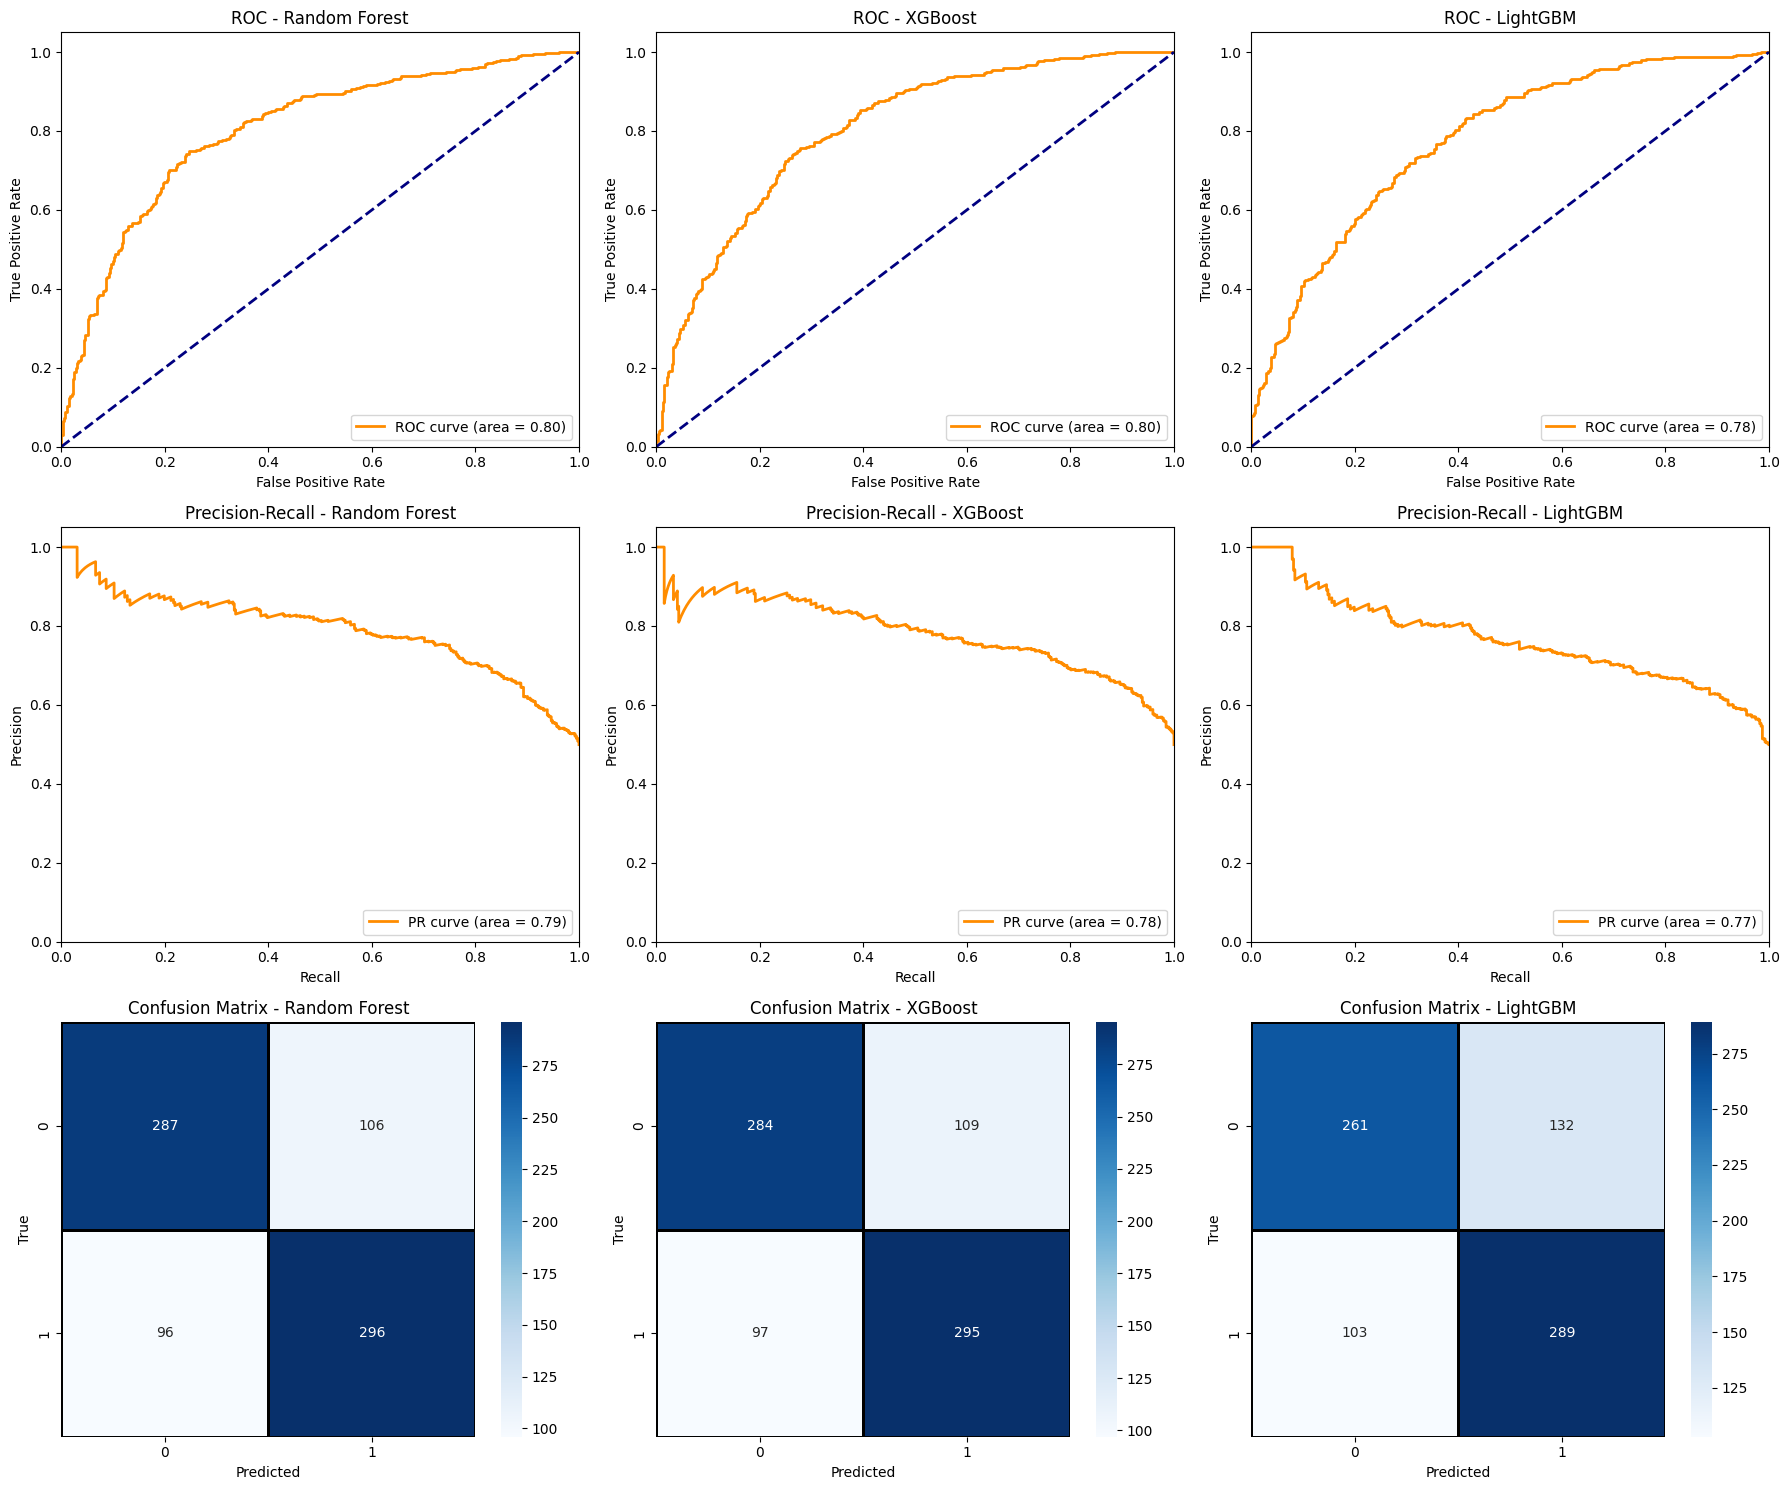

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.7426751592356687, 'Precision': 0.736318407960199, 'Recall': 0.7551020408163265, 'F1 Score': 0.7455919395465994, 'ROC AUC': 0.8021628498727735}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7375796178343949, 'Precision': 0.7301980198019802, 'Recall': 0.7525510204081632, 'F1 Score': 0.7412060301507538, 'ROC AUC': 0.8039284416056498}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.7006369426751592, 'Precision': 0.6864608076009501, 'Recall': 0.7372448979591837, 'F1 Score': 0.7109471094710945, 'ROC AUC': 0.77659422547645}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.7006369426751592,
 'Precision': 0.6864608076009501,
 'Recall': 0.7372448979591837,
 'F1 Score': 0.7109471094710945,
 'ROC AUC': 0.77659422547645}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.7427


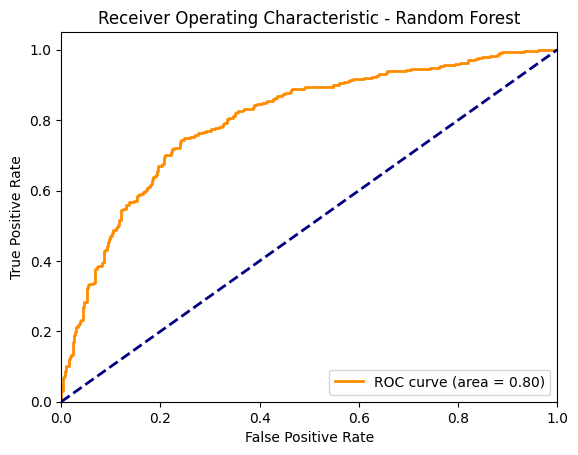

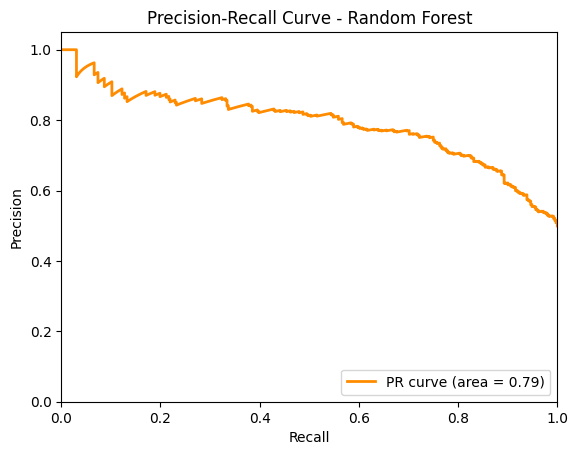

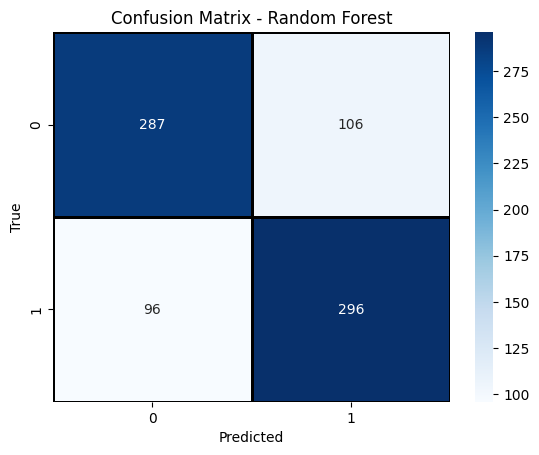

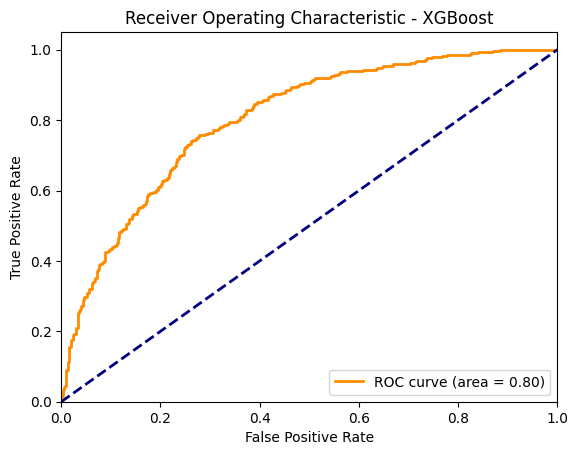

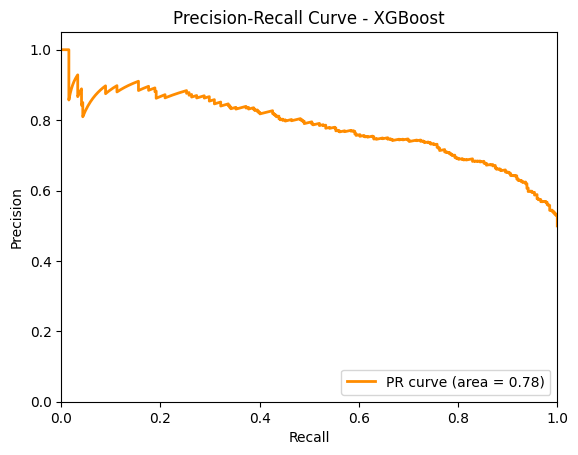

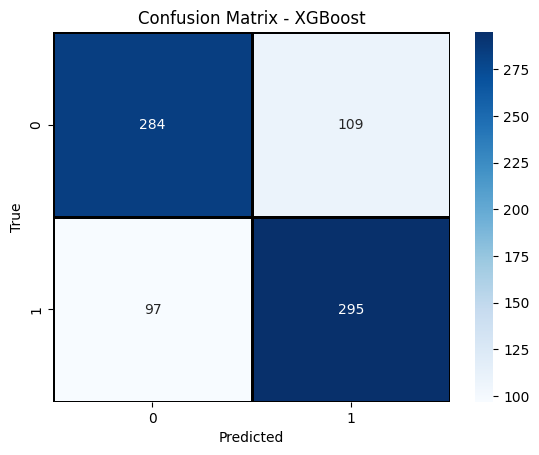

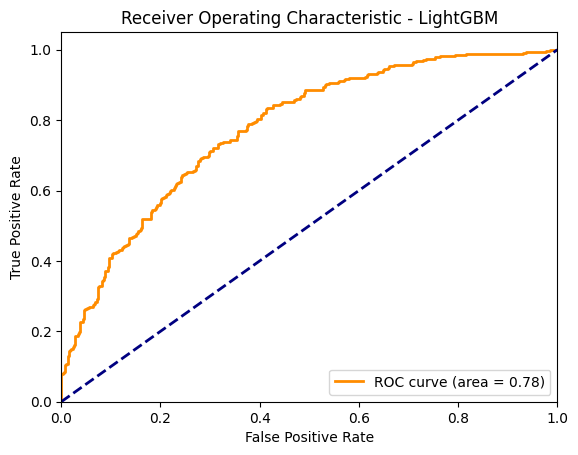

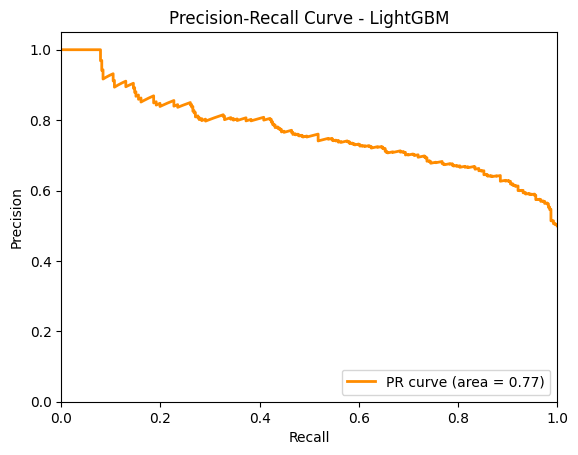

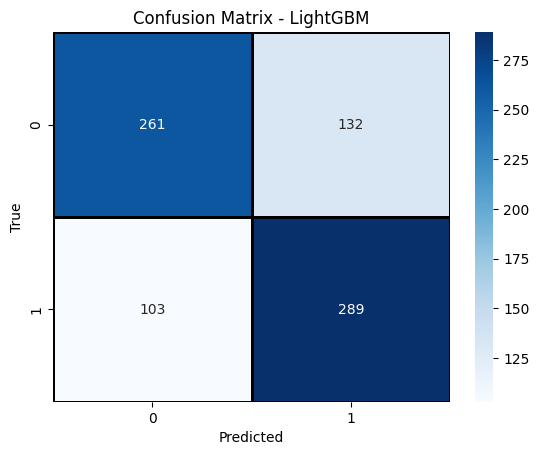

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

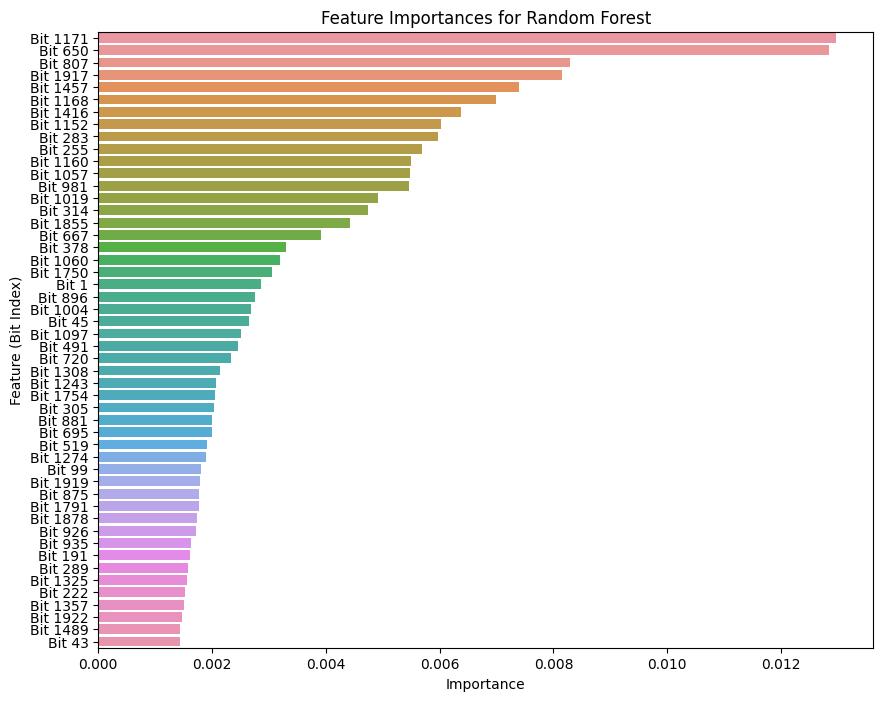

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
